Part b of project. Use Ridge and OLS. Also use a neural network.

Importing different libraries and defining activation / cost functions.

In [377]:
import autograd.numpy as np  # We need to use this numpy wrapper to make automatic differentiation work later
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Defining some activation functions and their derivatives
def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    da_dz = sigmoid(z) * (1 - sigmoid(z))
    return da_dz

def mse(predict, target):
    return np.mean((predict - target) ** 2)

def mse_der(predict, target):
    dC_da = 2/len(target) * (predict - target)
    return dC_da

def R2(predict, target):
    return 1 - np.sum((target - predict) ** 2) / np.sum((target - np.mean(target)) ** 2)

def identity_function(z):
    return z

def identity_der(z):
    return np.ones_like(z)


Defining our functions for our feed forward loop and back propagation. These are not batched as we use a simple one-dimensional example!

In [ ]:
def create_layers(network_input_size, layer_output_sizes):
    layers = []

    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(layer_output_size, i_size)
        b = np.random.randn(layer_output_size, 1)
        layers.append((W, b))

        i_size = layer_output_size
    return layers

def feed_forward(input, layers, activation_funcs):
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = W @ a + b
        a = activation_func(z)
    return a

def cost(layers, input, activation_funcs, target):
    predict = feed_forward(input, layers, activation_funcs)
    return mse(predict, target)

def feed_forward_saver(input, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = W @ a + b
        a = activation_func(z)

        zs.append(z)

    return layer_inputs, zs, a

def backpropagation(
    input, layers, activation_funcs, target, activation_ders, cost_der=mse_der
):
    layer_inputs, zs, predict = feed_forward_saver(input, layers, activation_funcs)

    layer_grads = [() for layer in layers]

    # We loop over the layers, from the last to the first
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # For last layer we use cost derivative as dC_da(L) can be computed directly
            dC_da = cost_der(predict, target)
        else:
            # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
            (W, b) = layers[i + 1]
            dC_da = W.T @ dC_dz

        dC_dz = dC_da * activation_der(z)
        dC_dW = dC_dz @ layer_input.T
        dC_db = np.sum(dC_dz, axis=1, keepdims=True)

        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

def new_layers(layers, layers_grad, learning_rate=0.01):
    new_layers = []
    for (W, b), (W_g, b_g) in zip(layers, layers_grad):
        W -= learning_rate * W_g
        b -= learning_rate * b_g
        new_layers.append((W, b))
    return new_layers

def train_network(x, layers, activation_funcs, target, learning_rate=0.1, epochs=1000):
    for epoch in range(epochs):
        layer_grads = backpropagation(x, layers, activation_funcs, target, activation_ders)
        layers = new_layers(layers, layer_grads, learning_rate)
    return layers


Generating data, and deciding the number of layers and output functions.

MSE for OLS: 3.024763881553529e-28
R2 for OLS: 1.0


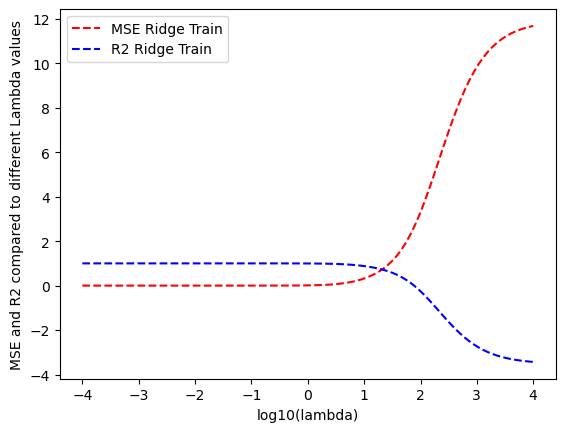

MSE for Ridge: 0.00037343459865159175
R2 for Ridge: 0.9998582891593671


In [379]:
np.random.seed(666)
x = np.random.rand(100)
#print("Our x-values:", x)
target = x**2 * 3 + x * 2 + 1
#print("Our target:", target)

X = np.ones((len(x), 3))
X[:,0] = 1
X[:,1] = x
X[:,2] = x**2

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.2)
x_train, x_test = train_test_split(x, test_size=0.2)

#OLS
beta_ols = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ target_train
predict_ols = X_test @ beta_ols

#print("Our OLS prediction:", predict_ols)
print("MSE for OLS:", mse(predict_ols, target_test))
print("R2 for OLS:", R2(predict_ols, target_test))

#Ridge
I = np.eye(3, 3)
nlambdas = 100
mse_ridge = np.zeros(nlambdas)
r2_ridge = np.zeros(nlambdas)
lambdas = np.logspace(-4, 4, nlambdas)

for i in range(nlambdas):
    lmb = lambdas[i]
    beta_ridge = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ target_train
    # and then make the prediction
    predict_ridge = X_test @ beta_ridge
    mse_ridge[i] = mse(predict_ridge, target_test)
    r2_ridge[i] = R2(predict_ridge, target_test)

# Now plot the results
plt.figure()
plt.plot(np.log10(lambdas), mse_ridge, 'r--', label = 'MSE Ridge Train')
plt.plot(np.log10(lambdas), r2_ridge, 'b--', label = 'R2 Ridge Train')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE and R2 compared to different Lambda values')
plt.legend()
plt.show()

#Choose lambda accordingly
lmb = 10**-1
beta_ridge = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ target_train
predict_ridge = X_test @ beta_ridge

#print("Our Ridge prediction:", predict_ridge)
print("MSE for Ridge:", mse(predict_ridge, target_test))
print("R2 for Ridge:", R2(predict_ridge, target_test))


Comparing with autograd (this gives the same result). So we use our own function in the network training.

In [380]:
#FFNN
network_input_size = X_train.shape[1]
layer_output_sizes = [3, 2, 1] #Last output must be same dimensionality as X (1)
activation_funcs = [sigmoid, sigmoid, identity_function]
activation_ders = [sigmoid_der, sigmoid_der, identity_der]

layers = create_layers(network_input_size, layer_output_sizes)
#print(layer_grads)

#Initial MSE and R2 (no training)
initial_prediction = feed_forward(X_train.T, layers, activation_funcs)
initial_mse = mse(initial_prediction, target_train)
initial_r2 = R2(initial_prediction, target_train)
print("Initial MSE (Training):", initial_mse)
print("Initial R2 (Training):", initial_r2)

#Training
layers = train_network(X_train.T, layers, activation_funcs, target_train)

#Final MSE and R2 (after training)
final_prediction = feed_forward(X_train.T, layers, activation_funcs)
final_mse = mse(final_prediction, target_train)
final_r2 = R2(final_prediction, target_train)
print("Final MSE (Training):", final_mse)
print("Final R2 (Training):", final_r2)

Initial MSE (Training): 18.494200695493095
Initial R2 (Training): -7.29134441759342
Final MSE (Training): 0.0062879779108729415
Final R2 (Training): 0.9971809654600552


Now use this trained network on our test data.

In [381]:
#Test network
test_prediction = feed_forward(X_test.T, layers, activation_funcs)
test_mse = mse(test_prediction, target_test)
test_r2 = R2(test_prediction, target_test) 

print("Test Data MSE:", test_mse)
print("Tets Data R2:", test_r2)

Test Data MSE: 0.010395362051850713
Tets Data R2: 0.9960551713730601
